In [1]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), 512 bytes | 11.00 KiB/s, done.
From https://github.com/nikitakuklev/APSopt-workspaces
   52b3025..e1d42ed  master     -> origin/master
Updating 52b3025..e1d42ed
Fast-forward
 nsls-ii/scripts/gen3_shared.py | 10 +++++-----
 1 file changed, 5 insertions(+), 5 deletions(-)


In [2]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [3]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2P12345_SL3P12345_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'mggpo_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,SL3-P5,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,7.135584,7.135584,7.135584,7.135584,-5.892172,...,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,SL3-P5,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.47599,-0.140523,-0.379702,-0.318519,-0.85627,-0.85627,-0.85627,-0.85627,-0.85627,-0.707061,...,-0.707061,-0.47599,-0.47599,-0.47599,-0.140523,-0.140523,-0.140523,-0.379702,-0.379702,-0.379702
1,0.47599,0.140523,0.379702,0.318519,0.85627,0.85627,0.85627,0.85627,0.85627,0.707061,...,0.707061,0.47599,0.47599,0.47599,0.140523,0.140523,0.140523,0.379702,0.379702,0.379702


In [4]:
#TEST_MODE = True
TEST_MODE = False

In [5]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.476 -> +3.491
SH3N   : -1.171 + -0.141 -> -1.312
SH4N   : -3.164 + -0.380 -> -3.544
SL1    : -2.654 + -0.319 -> -2.973
SL2-P1 : +7.136 + -0.856 -> +6.279
SL2-P2 : +7.136 + -0.856 -> +6.279
SL2-P3 : +7.136 + -0.856 -> +6.279
SL2-P4 : +7.136 + -0.856 -> +6.279
SL2-P5 : +7.136 + -0.856 -> +6.279
SL3-P1 : -5.892 + -0.707 -> -6.599
SL3-P2 : -5.892 + -0.707 -> -6.599
SL3-P3 : -5.892 + -0.707 -> -6.599
SL3-P4 : -5.892 + -0.707 -> -6.599
SL3-P5 : -5.892 + -0.707 -> -6.599
SH1-DW08: +3.967 + -0.476 -> +3.491
SH1-DW18: +3.967 + -0.476 -> +3.491
SH1-DW28: +3.967 + -0.476 -> +3.491
SH3-DW08: -1.171 + -0.141 -> -1.312
SH3-DW18: -1.171 + -0.141 -> -1.312
SH3-DW28: -1.171 + -0.141 -> -1.312
SH4-DW08: -3.164 + -0.380 -> -3.544
SH4-DW18: -3.164 + -0.380 -> -3.544
SH4-DW28: -3.164 + -0.380 -> -3.544


{'SH1N': 3.4905925296,
 'SH3N': -1.31154428384,
 'SH4N': -3.54388175904,
 'SL1': -2.9728397552000003,
 'SL2-P1': 6.279314175200001,
 'SL2-P2': 6.279314175200001,
 'SL2-P3': 6.279314175200001,
 'SL2-P4': 6.279314175200001,
 'SL2-P5': 6.279314175200001,
 'SL3-P1': -6.599232776640001,
 'SL3-P2': -6.599232776640001,
 'SL3-P3': -6.599232776640001,
 'SL3-P4': -6.599232776640001,
 'SL3-P5': -6.599232776640001,
 'SH1-DW08': 3.4905925296,
 'SH1-DW18': 3.4905925296,
 'SH1-DW28': 3.4905925296,
 'SH3-DW08': -1.31154428384,
 'SH3-DW18': -1.31154428384,
 'SH3-DW28': -1.31154428384,
 'SH4-DW08': -3.54388175904,
 'SH4-DW18': -3.54388175904,
 'SH4-DW28': -3.54388175904}

### Test eval function

In [6]:
# Test
if False and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [7]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

POP_SIZE = 8
generator_name = 'aps_mggpo'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs, population_size = POP_SIZE)
gen.reference_point = reference_point

[DEBUG][22:57:58.577 __init__.p   47] Creating converter from 7 to 5
[DEBUG][22:57:58.578 __init__.p   47] Creating converter from 5 to 7
[DEBUG][22:57:58.579 __init__.p   47] Creating converter from 7 to 5
[DEBUG][22:57:58.580 __init__.p   47] Creating converter from 5 to 7
[INFO ][22:57:58.635 generator.   16] Initializing generator aps_mggpo
[INFO ][22:57:58.636 generator.   64] Initialized generator aps_mggpo
[INFO ][22:57:58.636    moga.py   24] Initializing generator aps_moga
[INFO ][22:57:58.637 generator.   64] Initialized generator aps_moga
[INFO ][22:57:58.638   cnsga.py  283] Created toolbox with 23 variables, 0 constraints, and 2 objectives.
[INFO ][22:57:58.638   cnsga.py  286]     Using selection algorithm: nsga2


In [8]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][22:57:58.647 optimizer.   83] Initializing optimizer with tag='cd5ec93265' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][22:57:58.648 optimizer.  138] Generator set to: supports_batch_generation=False supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'S

### Sample at initial values

In [9]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][22:57:58.687 optimizer.  577] Evaluating 1 inputs
[DEBUG][22:57:58.690 evaluators  193] Data kwargs: row={'SH1N': -0.05, 'SH3N': 0.05, 'SH4N': -0.04, 'SL1': 0.08, 'SL2-P1': -0.27, 'SL2-P2': -0.34, 'SL2-P3': -0.41000000000000003, 'SL2-P4': -0.48000000000000004, 'SL2-P5': -0.55, 'SL3-P1': 0.13, 'SL3-P2': 0.06, 'SL3-P3': -0.010000000000000009, 'SL3-P4': -0.08000000000000002, 'SL3-P5': -0.15000000000000002, 'SH1-DW08': 0.025, 'SH1-DW18': -0.025, 'SH1-DW28': -0.025, 'SH3-DW08': 0.025, 'SH3-DW18': -0.025, 'SH3-DW28': -0.025, 'SH4-DW08': 0.025, 'SH4-DW18': -0.025, 'SH4-DW28': -0.025}
[INFO ][22:57:58.703 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9165824200000006, 'SH3N': -1.1210216819999999, 'SH4N': -3.2041801420000002, 'SL1': -2.5743212100000004, 'SL2-P1': 6.865584290000001, 'SL2-P2': 6.795584290000001, 'SL2-P3': 6.7255842900000005, 'SL2-P4': 6.65558429, 'SL2-P5': 6.585584290000001, 'SL3-P1': -5.762172122000001, 'SL3-P2': -5.832172122000001, 'SL3-P3': -5.9021721220000005, 'SL

SH1N   : +3.967 + -0.050 -> +3.917
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.040 -> -3.204
SL1    : -2.654 + +0.080 -> -2.574
SL2-P1 : +7.136 + -0.270 -> +6.866
SL2-P2 : +7.136 + -0.340 -> +6.796
SL2-P3 : +7.136 + -0.410 -> +6.726
SL2-P4 : +7.136 + -0.480 -> +6.656
SL2-P5 : +7.136 + -0.550 -> +6.586
SL3-P1 : -5.892 + +0.130 -> -5.762
SL3-P2 : -5.892 + +0.060 -> -5.832
SL3-P3 : -5.892 + -0.010 -> -5.902
SL3-P4 : -5.892 + -0.080 -> -5.972
SL3-P5 : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.025 -> +3.992
SH1-DW18: +3.967 + -0.025 -> +3.942
SH1-DW28: +3.967 + -0.025 -> +3.942
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.025 -> -1.196
SH3-DW28: -1.171 + -0.025 -> -1.196
SH4-DW08: -3.164 + +0.025 -> -3.139
SH4-DW18: -3.164 + -0.025 -> -3.189
SH4-DW28: -3.164 + -0.025 -> -3.189
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.079; RMS(dx, dy) [m] = (5.980e-06, 1.096e-06)
Orbit correction converged


[INFO ][22:58:04.137 opt_funcs.  734] Lifetime measurement START
[INFO ][22:58:17.638 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 5.538 (raw tau [hr] = 5.894, epsy [pm] = 17.00) (took 13.5 [s])
Inj. Eff. = 2.95 (took 14.0 [s])
Eval. func. finished.


[DEBUG][22:58:31.684 evaluators  211] Result: output={'result': {'_nux': 0.21484242573257942, '_nuy': 0.2661421556059125, '_eps_x_bxbOn': 1.0020854425606906e-09, '_eps_y_bxbOn': 1.712824458038894e-11, '_eps_x_bxbOff': 1.0026702074434204e-09, '_eps_y_bxbOff': 1.6996425482417925e-11, 'LT': 5.537708379484085, '_raw_LT': 5.894315163397046, 'EFF': 2.948486234675059}, 'exception': None, 'traceback': '', 'wall_time': 32.99224962666631, 'cpu_time': 19.281222056999997}
[DEBUG][22:58:31.686 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:58:31.699 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00000.json] in [0.00891]s


MOGA add_data (+1): len(self._offspring)=1/8


In [10]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.05,0.05,-0.04,0.08,-0.27,-0.34,-0.41,-0.48,-0.55,0.13,...,True,0.214842,0.266142,1.002085e-09,1.712824e-11,1.002670e-09,1.699643e-11,5.537708,5.894315,2.948486


### Sample close to initial point

In [11]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=POP_SIZE-1, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][22:58:57.002 optimizer.  577] Evaluating 7 inputs
[DEBUG][22:58:57.005 evaluators  193] Data kwargs: row={'SH1-DW08': 0.005633161364322865, 'SH1-DW18': -0.01878206858297952, 'SH1-DW28': -0.04625275480897576, 'SH1N': -0.05692809791764554, 'SH3-DW08': 0.02215864384800385, 'SH3-DW18': -0.028268273221326776, 'SH3-DW28': -0.02308139306122864, 'SH3N': 0.052254949323065986, 'SH4-DW08': 0.010844080417716527, 'SH4-DW18': -0.010054894503614714, 'SH4-DW28': -0.024427028240775903, 'SH4N': -0.026680284954403798, 'SL1': 0.0731954101592586, 'SL2-P1': -0.27767535913375546, 'SL2-P2': -0.3331811859199608, 'SL2-P3': -0.422622080427092, 'SL2-P4': -0.4889393106676364, 'SL2-P5': -0.566306191346364, 'SL3-P1': 0.13087220039432335, 'SL3-P2': 0.0569678129658281, 'SL3-P3': -0.012942662431695728, 'SL3-P4': -0.10509984337168157, 'SL3-P5': -0.11741501465990453}
[INFO ][22:58:57.011 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9096543220823547, 'SH3N': -1.118766732676934, 'SH4N': -3.190860426954404, 'SL

SH1N   : +3.967 + -0.057 -> +3.910
SH3N   : -1.171 + +0.052 -> -1.119
SH4N   : -3.164 + -0.027 -> -3.191
SL1    : -2.654 + +0.073 -> -2.581
SL2-P1 : +7.136 + -0.278 -> +6.858
SL2-P2 : +7.136 + -0.333 -> +6.802
SL2-P3 : +7.136 + -0.423 -> +6.713
SL2-P4 : +7.136 + -0.489 -> +6.647
SL2-P5 : +7.136 + -0.566 -> +6.569
SL3-P1 : -5.892 + +0.131 -> -5.761
SL3-P2 : -5.892 + +0.057 -> -5.835
SL3-P3 : -5.892 + -0.013 -> -5.905
SL3-P4 : -5.892 + -0.105 -> -5.997
SL3-P5 : -5.892 + -0.117 -> -6.010
SH1-DW08: +3.967 + +0.006 -> +3.972
SH1-DW18: +3.967 + -0.019 -> +3.948
SH1-DW28: +3.967 + -0.046 -> +3.920
SH3-DW08: -1.171 + +0.022 -> -1.149
SH3-DW18: -1.171 + -0.028 -> -1.199
SH3-DW28: -1.171 + -0.023 -> -1.194
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.010 -> -3.174
SH4-DW28: -3.164 + -0.024 -> -3.189
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (8.443e-07, 1.090e-06)
Orbit correction converged


[INFO ][22:59:01.092 opt_funcs.  734] Lifetime measurement START
[INFO ][22:59:05.542 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 5.449 (raw tau [hr] = 5.779, epsy [pm] = 16.90) (took 4.4 [s])
Inj. Eff. = 3.48 (took 15.0 [s])
Eval. func. finished.


[DEBUG][22:59:20.578 evaluators  211] Result: output={'result': {'_nux': 0.2141100056238034, '_nuy': 0.2659285292952406, '_eps_x_bxbOn': 1.0074344571383504e-09, '_eps_y_bxbOn': 1.7063891744740097e-11, '_eps_x_bxbOff': 1.0052646103567096e-09, '_eps_y_bxbOff': 1.6898427810821275e-11, 'LT': 5.449459553260913, '_raw_LT': 5.779384287682271, 'EFF': 3.478720981211423}, 'exception': None, 'traceback': '', 'wall_time': 23.572401251643896, 'cpu_time': 10.503888482000004}
[DEBUG][22:59:20.579 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03896149383038801, 'SH1-DW18': -0.035317985293287446, 'SH1-DW28': -0.0034706822441286714, 'SH1N': -0.041915890746804026, 'SH3-DW08': 0.026703750025382354, 'SH3-DW18': -0.02260891216367572, 'SH3-DW28': -0.0269053504792722, 'SH3N': 0.04470376577762679, 'SH4-DW08': 0.026525906685667785, 'SH4-DW18': -0.033878094207428634, 'SH4-DW28': -0.025703582839054658, 'SH4N': -0.04931299812047844, 'SL1': 0.0879242120655068, 'SL2-P1': -0.24221457467974206, 'SL2-P2': -0.3573928

SH1N   : +3.967 + -0.042 -> +3.925
SH3N   : -1.171 + +0.045 -> -1.126
SH4N   : -3.164 + -0.049 -> -3.213
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.242 -> +6.893
SL2-P2 : +7.136 + -0.357 -> +6.778
SL2-P3 : +7.136 + -0.400 -> +6.736
SL2-P4 : +7.136 + -0.446 -> +6.689
SL2-P5 : +7.136 + -0.543 -> +6.593
SL3-P1 : -5.892 + +0.128 -> -5.764
SL3-P2 : -5.892 + +0.082 -> -5.810
SL3-P3 : -5.892 + +0.002 -> -5.890
SL3-P4 : -5.892 + -0.045 -> -5.937
SL3-P5 : -5.892 + -0.159 -> -6.051
SH1-DW08: +3.967 + +0.039 -> +4.006
SH1-DW18: +3.967 + -0.035 -> +3.931
SH1-DW28: +3.967 + -0.003 -> +3.963
SH3-DW08: -1.171 + +0.027 -> -1.144
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.027 -> -3.138
SH4-DW18: -3.164 + -0.034 -> -3.198
SH4-DW28: -3.164 + -0.026 -> -3.190
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.005; RMS(dx, dy) [m] = (1.063e-06, 1.103e-06)
Orbit correction converged


[INFO ][22:59:24.657 opt_funcs.  734] Lifetime measurement START
[INFO ][22:59:38.156 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 5.546 (raw tau [hr] = 5.900, epsy [pm] = 17.07) (took 13.5 [s])
Inj. Eff. = 9.32 (took 17.3 [s])
Eval. func. finished.


[DEBUG][22:59:55.446 evaluators  211] Result: output={'result': {'_nux': 0.21769072279653448, '_nuy': 0.26605060435196404, '_eps_x_bxbOn': 1.00315675612341e-09, '_eps_y_bxbOn': 1.6973216501406397e-11, '_eps_x_bxbOff': 1.0045219341475476e-09, '_eps_y_bxbOff': 1.7069196626911278e-11, 'LT': 5.546258090930527, '_raw_LT': 5.900206880317342, 'EFF': 9.31977101187392}, 'exception': None, 'traceback': '', 'wall_time': 34.866589651443064, 'cpu_time': 19.897359575000003}
[DEBUG][22:59:55.447 evaluators  193] Data kwargs: row={'SH1-DW08': 0.029970067060599036, 'SH1-DW18': -0.0074498622751561425, 'SH1-DW28': -0.03365499772626382, 'SH1N': -0.06392235945559578, 'SH3-DW08': 0.03177937970783378, 'SH3-DW18': -0.019754020278203725, 'SH3-DW28': -0.018530907174335448, 'SH3N': 0.049836329016678574, 'SH4-DW08': 0.03997670728220961, 'SH4-DW18': -0.0369963342523598, 'SH4-DW28': -0.03810123258776012, 'SH4N': -0.058776368017132194, 'SL1': 0.07146743225142232, 'SL2-P1': -0.31029630641767386, 'SL2-P2': -0.36158365

SH1N   : +3.967 + -0.064 -> +3.903
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.059 -> -3.223
SL1    : -2.654 + +0.071 -> -2.583
SL2-P1 : +7.136 + -0.310 -> +6.825
SL2-P2 : +7.136 + -0.362 -> +6.774
SL2-P3 : +7.136 + -0.445 -> +6.691
SL2-P4 : +7.136 + -0.473 -> +6.663
SL2-P5 : +7.136 + -0.575 -> +6.560
SL3-P1 : -5.892 + +0.106 -> -5.786
SL3-P2 : -5.892 + +0.039 -> -5.853
SL3-P3 : -5.892 + -0.038 -> -5.930
SL3-P4 : -5.892 + -0.076 -> -5.968
SL3-P5 : -5.892 + -0.145 -> -6.038
SH1-DW08: +3.967 + +0.030 -> +3.997
SH1-DW18: +3.967 + -0.007 -> +3.959
SH1-DW28: +3.967 + -0.034 -> +3.933
SH3-DW08: -1.171 + +0.032 -> -1.139
SH3-DW18: -1.171 + -0.020 -> -1.191
SH3-DW28: -1.171 + -0.019 -> -1.190
SH4-DW08: -3.164 + +0.040 -> -3.124
SH4-DW18: -3.164 + -0.037 -> -3.201
SH4-DW28: -3.164 + -0.038 -> -3.202
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.035; RMS(dx, dy) [m] = (8.958e-07, 1.121e-06)
Orbit correction converged


[INFO ][22:59:59.528 opt_funcs.  734] Lifetime measurement START
[INFO ][23:00:04.444 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 5.243 (raw tau [hr] = 5.544, epsy [pm] = 16.65) (took 4.9 [s])
Inj. Eff. = -0.28 (took 14.0 [s])
Eval. func. finished.


[DEBUG][23:00:18.474 evaluators  211] Result: output={'result': {'_nux': 0.2141100089828661, '_nuy': 0.2659285292952406, '_eps_x_bxbOn': 1.0061253020179878e-09, '_eps_y_bxbOn': 1.6665874549290428e-11, '_eps_x_bxbOff': 1.0040464185468989e-09, '_eps_y_bxbOff': 1.6653040079139296e-11, 'LT': 5.243315481109521, '_raw_LT': 5.544313311552443, 'EFF': -0.2767881040182062}, 'exception': None, 'traceback': '', 'wall_time': 23.02524899598211, 'cpu_time': 11.171337027000007}
[DEBUG][23:00:18.475 evaluators  193] Data kwargs: row={'SH1-DW08': 0.014305421967612494, 'SH1-DW18': -0.03846608523198421, 'SH1-DW28': -0.016252874192226555, 'SH1N': -0.03719933475746049, 'SH3-DW08': 0.020208189086154724, 'SH3-DW18': -0.02936836553671915, 'SH3-DW28': -0.031456618665416276, 'SH3N': 0.0541484090181782, 'SH4-DW08': 0.017620584499902295, 'SH4-DW18': -0.022630367107376786, 'SH4-DW28': -0.010878149511156628, 'SH4N': -0.03620827345023408, 'SL1': 0.08965194786032411, 'SL2-P1': -0.24939664910314566, 'SL2-P2': -0.305513

SH1N   : +3.967 + -0.037 -> +3.929
SH3N   : -1.171 + +0.054 -> -1.117
SH4N   : -3.164 + -0.036 -> -3.200
SL1    : -2.654 + +0.090 -> -2.565
SL2-P1 : +7.136 + -0.249 -> +6.886
SL2-P2 : +7.136 + -0.306 -> +6.830
SL2-P3 : +7.136 + -0.378 -> +6.758
SL2-P4 : +7.136 + -0.516 -> +6.620
SL2-P5 : +7.136 + -0.513 -> +6.623
SL3-P1 : -5.892 + +0.152 -> -5.740
SL3-P2 : -5.892 + +0.064 -> -5.828
SL3-P3 : -5.892 + +0.008 -> -5.884
SL3-P4 : -5.892 + -0.092 -> -5.984
SL3-P5 : -5.892 + -0.184 -> -6.076
SH1-DW08: +3.967 + +0.014 -> +3.981
SH1-DW18: +3.967 + -0.038 -> +3.928
SH1-DW28: +3.967 + -0.016 -> +3.950
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.029 -> -1.200
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + +0.018 -> -3.147
SH4-DW18: -3.164 + -0.023 -> -3.187
SH4-DW28: -3.164 + -0.011 -> -3.175
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.028; RMS(dx, dy) [m] = (1.071e-06, 1.284e-06)
Orbit correction converged


[INFO ][23:00:22.587 opt_funcs.  734] Lifetime measurement START
[INFO ][23:00:29.067 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 5.651 (raw tau [hr] = 6.055, epsy [pm] = 17.08) (took 6.5 [s])
Inj. Eff. = 8.70 (took 17.3 [s])
Eval. func. finished.


[DEBUG][23:00:46.392 evaluators  211] Result: output={'result': {'_nux': 0.21453724816795905, '_nuy': 0.26611163180313757, '_eps_x_bxbOn': 1.0058641294930136e-09, '_eps_y_bxbOn': 1.7148062685176448e-11, '_eps_x_bxbOff': 1.0029550741108093e-09, '_eps_y_bxbOff': 1.7077407054690258e-11, 'LT': 5.650855950054237, '_raw_LT': 6.055424824043163, 'EFF': 8.697717263091658}, 'exception': None, 'traceback': '', 'wall_time': 27.91592258680612, 'cpu_time': 12.66456660899999}
[DEBUG][23:00:46.393 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019807265766958605, 'SH1-DW18': -0.003387744263864595, 'SH1-DW28': -0.012143259870219456, 'SH1N': -0.027305746178427598, 'SH3-DW08': 0.019599461456859205, 'SH3-DW18': -0.025325633016873378, 'SH3-DW28': -0.019972943441431225, 'SH3N': 0.04740731271909687, 'SH4-DW08': 0.03534682746872688, 'SH4-DW18': -0.029594987017392122, 'SH4-DW28': -0.04375699754948026, 'SH4N': -0.033110834549291986, 'SL1': 0.06536279270756493, 'SL2-P1': -0.23398849192707005, 'SL2-P2': -0.3148

SH1N   : +3.967 + -0.027 -> +3.939
SH3N   : -1.171 + +0.047 -> -1.124
SH4N   : -3.164 + -0.033 -> -3.197
SL1    : -2.654 + +0.065 -> -2.589
SL2-P1 : +7.136 + -0.234 -> +6.902
SL2-P2 : +7.136 + -0.315 -> +6.821
SL2-P3 : +7.136 + -0.373 -> +6.763
SL2-P4 : +7.136 + -0.506 -> +6.630
SL2-P5 : +7.136 + -0.525 -> +6.610
SL3-P1 : -5.892 + +0.100 -> -5.793
SL3-P2 : -5.892 + +0.044 -> -5.849
SL3-P3 : -5.892 + -0.020 -> -5.912
SL3-P4 : -5.892 + -0.109 -> -6.001
SL3-P5 : -5.892 + -0.139 -> -6.031
SH1-DW08: +3.967 + +0.020 -> +3.986
SH1-DW18: +3.967 + -0.003 -> +3.963
SH1-DW28: +3.967 + -0.012 -> +3.954
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.025 -> -1.196
SH3-DW28: -1.171 + -0.020 -> -1.191
SH4-DW08: -3.164 + +0.035 -> -3.129
SH4-DW18: -3.164 + -0.030 -> -3.194
SH4-DW28: -3.164 + -0.044 -> -3.208
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.088; RMS(dx, dy) [m] = (1.284e-06, 1.284e-06)
Orbit correction converged


[INFO ][23:00:50.578 opt_funcs.  734] Lifetime measurement START
[INFO ][23:01:02.024 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 5.693 (raw tau [hr] = 6.112, epsy [pm] = 17.11) (took 11.4 [s])
Inj. Eff. = 2.28 (took 15.0 [s])
Eval. func. finished.


[DEBUG][23:01:17.057 evaluators  211] Result: output={'result': {'_nux': 0.21401845436985492, '_nuy': 0.26605060435196404, '_eps_x_bxbOn': 1.0028556266635186e-09, '_eps_y_bxbOn': 1.7217617214289895e-11, '_eps_x_bxbOff': 1.0015194840735058e-09, '_eps_y_bxbOff': 1.71102357575638e-11, 'LT': 5.692529518489171, '_raw_LT': 6.111508483161327, 'EFF': 2.2832093811999488}, 'exception': None, 'traceback': '', 'wall_time': 30.66351639572531, 'cpu_time': 17.736801103999994}
[DEBUG][23:01:17.058 evaluators  193] Data kwargs: row={'SH1-DW08': 0.035566123130772495, 'SH1-DW18': -0.043259056830094615, 'SH1-DW28': -0.03776134448162542, 'SH1N': -0.07160816904502185, 'SH3-DW08': 0.02931760982067309, 'SH3-DW18': -0.023796762023006873, 'SH3-DW28': -0.030039961070945642, 'SH3N': 0.05561692539891483, 'SH4-DW08': 0.022481361007025757, 'SH4-DW18': -0.015227863096160654, 'SH4-DW28': -0.007041011957299309, 'SH4N': -0.05089528888806305, 'SL1': 0.09550829185978099, 'SL2-P1': -0.2854821878527855, 'SL2-P2': -0.3764157

SH1N   : +3.967 + -0.072 -> +3.895
SH3N   : -1.171 + +0.056 -> -1.115
SH4N   : -3.164 + -0.051 -> -3.215
SL1    : -2.654 + +0.096 -> -2.559
SL2-P1 : +7.136 + -0.285 -> +6.850
SL2-P2 : +7.136 + -0.376 -> +6.759
SL2-P3 : +7.136 + -0.439 -> +6.696
SL2-P4 : +7.136 + -0.463 -> +6.673
SL2-P5 : +7.136 + -0.587 -> +6.549
SL3-P1 : -5.892 + +0.159 -> -5.733
SL3-P2 : -5.892 + +0.095 -> -5.797
SL3-P3 : -5.892 + -0.009 -> -5.901
SL3-P4 : -5.892 + -0.062 -> -5.954
SL3-P5 : -5.892 + -0.171 -> -6.063
SH1-DW08: +3.967 + +0.036 -> +4.002
SH1-DW18: +3.967 + -0.043 -> +3.923
SH1-DW28: +3.967 + -0.038 -> +3.929
SH3-DW08: -1.171 + +0.029 -> -1.142
SH3-DW18: -1.171 + -0.024 -> -1.195
SH3-DW28: -1.171 + -0.030 -> -1.201
SH4-DW08: -3.164 + +0.022 -> -3.142
SH4-DW18: -3.164 + -0.015 -> -3.179
SH4-DW28: -3.164 + -0.007 -> -3.171
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.016; RMS(dx, dy) [m] = (1.097e-06, 1.173e-06)
Orbit correction converged


[INFO ][23:01:21.160 opt_funcs.  734] Lifetime measurement START
[INFO ][23:01:25.092 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 5.132 (raw tau [hr] = 5.452, epsy [pm] = 16.81) (took 3.9 [s])
Inj. Eff. = 3.31 (took 15.0 [s])
Eval. func. finished.


[DEBUG][23:01:40.127 evaluators  211] Result: output={'result': {'_nux': 0.21438466946283696, '_nuy': 0.26598957690079045, '_eps_x_bxbOn': 1.0049901632993765e-09, '_eps_y_bxbOn': 1.6846982260331072e-11, '_eps_x_bxbOff': 1.0045132764111696e-09, '_eps_y_bxbOff': 1.680581512419076e-11, 'LT': 5.1315566214433, '_raw_LT': 5.451630961187568, 'EFF': 3.3081298738076823}, 'exception': None, 'traceback': '', 'wall_time': 23.06860866677016, 'cpu_time': 10.268161699000004}
[DEBUG][23:01:40.128 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04461565271337618, 'SH1-DW18': -0.022921149171377015, 'SH1-DW28': -0.020185647261553245, 'SH1N': -0.04597022352734555, 'SH3-DW08': 0.02731247147839272, 'SH3-DW18': -0.019622941742983364, 'SH3-DW28': -0.02430074371649129, 'SH3N': 0.05026517174657716, 'SH4-DW08': 0.006268082260875032, 'SH4-DW18': -0.018645123835861022, 'SH4-DW28': -0.019364863319368417, 'SH4N': -0.04135864182020602, 'SL1': 0.07906342039152336, 'SL2-P1': -0.2682820043818037, 'SL2-P2': -0.350588296

SH1N   : +3.967 + -0.046 -> +3.921
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.041 -> -3.206
SL1    : -2.654 + +0.079 -> -2.575
SL2-P1 : +7.136 + -0.268 -> +6.867
SL2-P2 : +7.136 + -0.351 -> +6.785
SL2-P3 : +7.136 + -0.395 -> +6.741
SL2-P4 : +7.136 + -0.457 -> +6.678
SL2-P5 : +7.136 + -0.533 -> +6.603
SL3-P1 : -5.892 + +0.146 -> -5.746
SL3-P2 : -5.892 + +0.026 -> -5.866
SL3-P3 : -5.892 + -0.031 -> -5.923
SL3-P4 : -5.892 + -0.066 -> -5.958
SL3-P5 : -5.892 + -0.131 -> -6.024
SH1-DW08: +3.967 + +0.045 -> +4.011
SH1-DW18: +3.967 + -0.023 -> +3.944
SH1-DW28: +3.967 + -0.020 -> +3.946
SH3-DW08: -1.171 + +0.027 -> -1.144
SH3-DW18: -1.171 + -0.020 -> -1.191
SH3-DW28: -1.171 + -0.024 -> -1.195
SH4-DW08: -3.164 + +0.006 -> -3.158
SH4-DW18: -3.164 + -0.019 -> -3.183
SH4-DW28: -3.164 + -0.019 -> -3.184
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.030; RMS(dx, dy) [m] = (1.864e-06, 1.357e-06)
Orbit correction converged


[INFO ][23:01:44.212 opt_funcs.  734] Lifetime measurement START
[INFO ][23:01:48.630 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 5.539 (raw tau [hr] = 5.885, epsy [pm] = 16.88) (took 4.4 [s])
Inj. Eff. = 4.85 (took 18.3 [s])
Eval. func. finished.


[DEBUG][23:02:06.884 evaluators  211] Result: output={'result': {'_nux': 0.2142727690070386, '_nuy': 0.2662031931342742, '_eps_x_bxbOn': 1.0038305931047616e-09, '_eps_y_bxbOn': 1.7045561662452768e-11, '_eps_x_bxbOff': 1.0031731592806723e-09, '_eps_y_bxbOff': 1.688434073701485e-11, 'LT': 5.5386665175094825, '_raw_LT': 5.884743418611031, 'EFF': 4.847878939901169}, 'exception': None, 'traceback': '', 'wall_time': 26.75487699173391, 'cpu_time': 10.744455723999991}
[DEBUG][23:02:06.887 optimizer.  291] Adding (7) new data to internal dataframes
[DEBUG][23:02:06.926 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00001.json] in [0.02612]s


MOGA add_data (+7): len(self._offspring)=8/8
MOGA add_data: creating next generation


In [12]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.050000,0.050000,-0.040000,0.080000,-0.270000,-0.340000,-0.410000,-0.480000,-0.550000,0.130000,...,True,0.214842,0.266142,1.002085e-09,1.712824e-11,1.002670e-09,1.699643e-11,5.537708,5.894315,2.948486
2,-0.056928,0.052255,-0.026680,0.073195,-0.277675,-0.333181,-0.422622,-0.488939,-0.566306,0.130872,...,True,0.214110,0.265929,1.007434e-09,1.706389e-11,1.005265e-09,1.689843e-11,5.449460,5.779384,3.478721
3,-0.041916,0.044704,-0.049313,0.087924,-0.242215,-0.357393,-0.400024,-0.446296,-0.543067,0.128430,...,True,0.217691,0.266051,1.003157e-09,1.697322e-11,1.004522e-09,1.706920e-11,5.546258,5.900207,9.319771
4,-0.063922,0.049836,-0.058776,0.071467,-0.310296,-0.361584,-0.444659,-0.472908,-0.575284,0.106042,...,True,0.214110,0.265929,1.006125e-09,1.666587e-11,1.004046e-09,1.665304e-11,5.243315,5.544313,-0.276788
5,-0.037199,0.054148,-0.036208,0.089652,-0.249397,-0.305514,-0.377909,-0.515886,-0.512562,0.152159,...,True,0.214537,0.266112,1.005864e-09,1.714806e-11,1.002955e-09,1.707741e-11,5.650856,6.055425,8.697717
6,-0.027306,0.047407,-0.033111,0.065363,-0.233988,-0.314827,-0.372826,-0.505725,-0.525403,0.099579,...,True,0.214018,0.266051,1.002856e-09,1.721762e-11,1.001519e-09,1.711024e-11,5.692530,6.111508,2.283209
7,-0.071608,0.055617,-0.050895,0.095508,-0.285482,-0.376416,-0.439199,-0.463084,-0.586773,0.158901,...,True,0.214385,0.265990,1.004990e-09,1.684698e-11,1.004513e-09,1.680582e-11,5.131557,5.451631,3.308130
8,-0.045970,0.050265,-0.041359,0.079063,-0.268282,-0.350588,-0.394946,-0.457461,-0.532987,0.146487,...,True,0.214273,0.266203,1.003831e-09,1.704556e-11,1.003173e-09,1.688434e-11,5.538667,5.884743,4.847879


### Run optimizer

In [13]:
opt.step()

[DEBUG][23:02:21.008 optimizer.  447] Generating 1 candidates
[DEBUG][23:02:21.010 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998],

SH1N   : +3.967 + -0.042 -> +3.925
SH3N   : -1.171 + +0.045 -> -1.126
SH4N   : -3.164 + -0.050 -> -3.214
SL1    : -2.654 + +0.110 -> -2.545
SL2-P1 : +7.136 + -0.242 -> +6.893
SL2-P2 : +7.136 + -0.358 -> +6.778
SL2-P3 : +7.136 + -0.377 -> +6.759
SL2-P4 : +7.136 + -0.593 -> +6.543
SL2-P5 : +7.136 + -0.543 -> +6.593
SL3-P1 : -5.892 + +0.128 -> -5.764
SL3-P2 : -5.892 + +0.082 -> -5.810
SL3-P3 : -5.892 + +0.002 -> -5.890
SL3-P4 : -5.892 + -0.045 -> -5.937
SL3-P5 : -5.892 + -0.160 -> -6.053
SH1-DW08: +3.967 + +0.040 -> +4.006
SH1-DW18: +3.967 + -0.035 -> +3.931
SH1-DW28: +3.967 + -0.003 -> +3.963
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.018 -> -3.147
SH4-DW18: -3.164 + -0.034 -> -3.198
SH4-DW28: -3.164 + -0.026 -> -3.190
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.037; RMS(dx, dy) [m] = (1.340e-06, 1.154e-06)
Orbit correction converged


[INFO ][23:02:26.605 opt_funcs.  734] Lifetime measurement START
[INFO ][23:02:34.138 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 5.398 (raw tau [hr] = 5.776, epsy [pm] = 16.90) (took 7.5 [s])
Inj. Eff. = 3.59 (took 14.0 [s])
Eval. func. finished.


[DEBUG][23:02:48.170 evaluators  211] Result: output={'result': {'_nux': 0.2106767983305768, '_nuy': 0.26586750184406704, '_eps_x_bxbOn': 1.0008550691441954e-09, '_eps_y_bxbOn': 1.685999555140709e-11, '_eps_x_bxbOff': 1.0010126774227554e-09, '_eps_y_bxbOff': 1.6897492008920905e-11, 'LT': 5.398222017106208, '_raw_LT': 5.7758016105547725, 'EFF': 3.589392798728592}, 'exception': None, 'traceback': '', 'wall_time': 26.674100253731012, 'cpu_time': 19.43138429000001}
[DEBUG][23:02:48.173 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][23:02:48.197 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00002.json] in [0.01995]s


MOGA add_data (+1): len(self._offspring)=1/8


In [22]:
for i in range(9):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][00:35:00.506 optimizer.  447] Generating 1 candidates
[DEBUG][00:35:00.508 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2-P1': [-0.8562701148, 0.8562701148], 'SL2-P2': [-0.8562701148, 0.8562701148], 'SL2-P3': [-0.8562701148, 0.8562701148], 'SL2-P4': [-0.8562701148, 0.8562701148], 'SL2-P5': [-0.8562701148, 0.8562701148], 'SL3-P1': [-0.70706065464, 0.70706065464], 'SL3-P2': [-0.70706065464, 0.70706065464], 'SL3-P3': [-0.70706065464, 0.70706065464], 'SL3-P4': [-0.70706065464, 0.70706065464], 'SL3-P5': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998],


** Step #1 at 2023-12-17 00:35:00**



[DEBUG][00:35:00.719   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=51)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:35:00.802 bayesian_g  248] Best candidate from optimize tensor([[ 0.0134, -0.2111,  0.0408, -0.0224,  0.0202,  0.0076, -0.0266,  0.0549,
          0.0354, -0.0226, -0.0110,  0.0131,  0.0884, -0.2337, -0.3147, -0.1745,
         -0.3281, -0.5125,  0.1511,  0.4749, -0.0193, -0.1630, -0.1255]],
       dtype=torch.float64)
[DEBUG][00:35:00.804 optimizer.  492] Generated 1 inputs
[INFO ][00:35:00.810 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:35:00.813 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013381891686521579, 'SH1-DW18': -0.21107268344660493, 'SH1-DW28': 0.04084619594607883, 'SH1N': -0.022390794641260887, 'SH3-DW08': 0.020199392588854774, 'SH3-DW18': 0.007569408045919858, 'SH

SH1N   : +3.967 + -0.022 -> +3.944
SH3N   : -1.171 + +0.055 -> -1.116
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.234 -> +6.902
SL2-P2 : +7.136 + -0.315 -> +6.821
SL2-P3 : +7.136 + -0.175 -> +6.961
SL2-P4 : +7.136 + -0.328 -> +6.807
SL2-P5 : +7.136 + -0.513 -> +6.623
SL3-P1 : -5.892 + +0.151 -> -5.741
SL3-P2 : -5.892 + +0.475 -> -5.417
SL3-P3 : -5.892 + -0.019 -> -5.911
SL3-P4 : -5.892 + -0.163 -> -6.055
SL3-P5 : -5.892 + -0.125 -> -6.018
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.211 -> +3.756
SH1-DW28: +3.967 + +0.041 -> +4.007
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.008 -> -1.163
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.035 -> -3.129
SH4-DW18: -3.164 + -0.023 -> -3.187
SH4-DW28: -3.164 + -0.011 -> -3.175
Sextupole adj. took 4.2.
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (4.458e-06, 1.137e-06)
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (4.458e-06, 1.137e-06)
Max FCOR I [A] = 0.027; RMS(dx,

[INFO ][00:35:11.008 opt_funcs.  734] Lifetime measurement START
[INFO ][00:35:16.400 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.512 (raw tau [hr] = 8.045, epsy [pm] = 17.26) (took 5.4 [s])
Inj. Eff. = 30.58 (took 18.5 [s])
Eval. func. finished.


[DEBUG][00:35:34.877 evaluators  211] Result: output={'result': {'_nux': 0.21356068802292436, '_nuy': 0.2635481765382037, '_eps_x_bxbOn': 9.876966687060203e-10, '_eps_y_bxbOn': 1.7285002424767044e-11, '_eps_x_bxbOff': 9.86117126360027e-10, '_eps_y_bxbOff': 1.725593056007093e-11, 'LT': 6.511913597179037, '_raw_LT': 8.045337161239155, 'EFF': 30.58418475906614}, 'exception': None, 'traceback': '', 'wall_time': 34.06305415183306, 'cpu_time': 17.353644607999968}
[DEBUG][00:35:34.879 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:35:34.950 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00045.json] in [0.06510]s
[DEBUG][00:35:34.951 optimizer.  447] Generating 1 candidates
[DEBUG][00:35:34.952 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], '

MOGA add_data (+1): len(self._offspring)=4/8

** Step #2 at 2023-12-17 00:35:34**



[DEBUG][00:35:35.121   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=52)
[DEBUG][00:35:35.222 bayesian_g  248] Best candidate from optimize tensor([[ 0.0134, -0.2103,  0.0408, -0.0141,  0.0201, -0.0092, -0.0314,  0.0621,
         -0.0692, -0.0222, -0.0110,  0.0131,  0.0884, -0.2482, -0.2187, -0.1744,
         -0.3281, -0.5125,  0.1511,  0.2469,  0.0015, -0.0932, -0.1845]],
       dtype=torch.float64)
[DEBUG][00:35:35.225 optimizer.  492] Generated 1 inputs
[INFO ][00:35:35.230 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:35:35.232 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013379462586507464, 'SH1-DW18': -0.21033873897449312, 'SH1-DW28': 0.040830001549711115, 'SH1N': -0.014074403480227387, 'SH3-DW08': 0.02009206043343205, 'SH3-DW18': -0.009163897126889285, 'SH3-DW28': -0.03139760801023678, 'SH3N': 0.06206896331261105, 'SH4-DW08': -0.06915793444222487, 'SH4-DW18': -0.022206618216211463, 'SH4-DW28': -0.010963845978421496, 'SH4N': 0.01305230047302007, 'SL

SH1N   : +3.967 + -0.014 -> +3.953
SH3N   : -1.171 + +0.062 -> -1.109
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.248 -> +6.887
SL2-P2 : +7.136 + -0.219 -> +6.917
SL2-P3 : +7.136 + -0.174 -> +6.961
SL2-P4 : +7.136 + -0.328 -> +6.807
SL2-P5 : +7.136 + -0.512 -> +6.623
SL3-P1 : -5.892 + +0.151 -> -5.741
SL3-P2 : -5.892 + +0.247 -> -5.645
SL3-P3 : -5.892 + +0.001 -> -5.891
SL3-P4 : -5.892 + -0.093 -> -5.985
SL3-P5 : -5.892 + -0.184 -> -6.077
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.210 -> +3.756
SH1-DW28: +3.967 + +0.041 -> +4.007
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.009 -> -1.180
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + -0.069 -> -3.233
SH4-DW18: -3.164 + -0.022 -> -3.186
SH4-DW28: -3.164 + -0.011 -> -3.175
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.056; RMS(dx, dy) [m] = (3.105e-06, 1.137e-06)
Orbit correction converged


[INFO ][00:35:41.358 opt_funcs.  734] Lifetime measurement START
[INFO ][00:35:48.783 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.716 (raw tau [hr] = 8.244, epsy [pm] = 17.01) (took 7.4 [s])
Inj. Eff. = 32.92 (took 17.7 [s])
Eval. func. finished.


[DEBUG][00:36:06.462 evaluators  211] Result: output={'result': {'_nux': 0.2134386331205772, '_nuy': 0.2637923165744624, '_eps_x_bxbOn': 9.918277263414057e-10, '_eps_y_bxbOn': 1.717019253275348e-11, '_eps_x_bxbOff': 9.904749034001804e-10, '_eps_y_bxbOff': 1.7009815027040445e-11, 'LT': 6.715759038265615, '_raw_LT': 8.244107424208789, 'EFF': 32.916853203371105}, 'exception': None, 'traceback': '', 'wall_time': 31.22918412927538, 'cpu_time': 19.532595993000086}
[DEBUG][00:36:06.464 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:36:06.533 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00046.json] in [0.06328]s
[DEBUG][00:36:06.533 optimizer.  447] Generating 1 candidates
[DEBUG][00:36:06.534 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 

MOGA add_data (+1): len(self._offspring)=5/8

** Step #3 at 2023-12-17 00:36:06**



[DEBUG][00:36:06.718   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=53)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:36:06.803 bayesian_g  248] Best candidate from optimize tensor([[ 0.0402, -0.2133,  0.0154, -0.0491,  0.0266, -0.0225, -0.0266,  0.0340,
          0.1703, -0.0342, -0.0134, -0.0487,  0.0885, -0.2338, -0.3147, -0.1717,
         -0.3243, -0.5126,  0.0998,  0.2471, -0.0195, -0.0472, -0.0315]],
       dtype=torch.float64)
[DEBUG][00:36:06.805 optimizer.  492] Generated 1 inputs
[INFO ][00:36:06.810 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:36:06.812 evaluators  193] Data kwargs: row={'SH1-DW08': 0.040234514589799125, 'SH1-DW18': -0.21330627671515162, 'SH1-DW28': 0.015381461645005957, 'SH1N': -0.04911188016024195, 'SH3-DW08': 0.02661886018948066, 'SH3-DW18': -0.022530193656232732, 'SH

SH1N   : +3.967 + -0.049 -> +3.917
SH3N   : -1.171 + +0.034 -> -1.137
SH4N   : -3.164 + -0.049 -> -3.213
SL1    : -2.654 + +0.089 -> -2.566
SL2-P1 : +7.136 + -0.234 -> +6.902
SL2-P2 : +7.136 + -0.315 -> +6.821
SL2-P3 : +7.136 + -0.172 -> +6.964
SL2-P4 : +7.136 + -0.324 -> +6.811
SL2-P5 : +7.136 + -0.513 -> +6.623
SL3-P1 : -5.892 + +0.100 -> -5.792
SL3-P2 : -5.892 + +0.247 -> -5.645
SL3-P3 : -5.892 + -0.020 -> -5.912
SL3-P4 : -5.892 + -0.047 -> -5.939
SL3-P5 : -5.892 + -0.031 -> -5.924
SH1-DW08: +3.967 + +0.040 -> +4.007
SH1-DW18: +3.967 + -0.213 -> +3.753
SH1-DW28: +3.967 + +0.015 -> +3.982
SH3-DW08: -1.171 + +0.027 -> -1.144
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.170 -> -2.994
SH4-DW18: -3.164 + -0.034 -> -3.198
SH4-DW28: -3.164 + -0.013 -> -3.178
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.057; RMS(dx, dy) [m] = (5.486e-06, 1.142e-06)
Orbit correction converged


[INFO ][00:36:12.940 opt_funcs.  734] Lifetime measurement START
[INFO ][00:36:19.316 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.148 (raw tau [hr] = 7.556, epsy [pm] = 17.03) (took 6.4 [s])
Inj. Eff. = 55.37 (took 17.7 [s])
Eval. func. finished.


[DEBUG][00:36:37.031 evaluators  211] Result: output={'result': {'_nux': 0.2126451754834395, '_nuy': 0.26369060079677703, '_eps_x_bxbOn': 9.905907917860573e-10, '_eps_y_bxbOn': 1.7116293509739775e-11, '_eps_x_bxbOff': 9.897286587979106e-10, '_eps_y_bxbOff': 1.703390861343385e-11, 'LT': 6.147704283763426, '_raw_LT': 7.556317789596133, 'EFF': 55.367356357344}, 'exception': None, 'traceback': '', 'wall_time': 30.217633940279484, 'cpu_time': 18.35632958899987}
[DEBUG][00:36:37.034 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:36:37.105 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00047.json] in [0.06454]s
[DEBUG][00:36:37.106 optimizer.  447] Generating 1 candidates
[DEBUG][00:36:37.108 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'S

MOGA add_data (+1): len(self._offspring)=6/8

** Step #4 at 2023-12-17 00:36:37**



[DEBUG][00:36:37.299   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=54)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:36:37.389 bayesian_g  248] Best candidate from optimize tensor([[ 0.0132, -0.0440,  0.0329, -0.0230,  0.0167, -0.0225, -0.0266,  0.0536,
          0.0354, -0.0339, -0.0138,  0.0139,  0.0884, -0.2334, -0.3147, -0.1743,
         -0.4494, -0.5250,  0.0986,  0.2471,  0.0013, -0.0436, -0.1261]],
       dtype=torch.float64)
[DEBUG][00:36:37.392 optimizer.  492] Generated 1 inputs
[INFO ][00:36:37.398 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:36:37.400 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013162655599477172, 'SH1-DW18': -0.04398347834163513, 'SH1-DW28': 0.03290945197202223, 'SH1N': -0.022980266722446734, 'SH3-DW08': 0.016669198816648904, 'SH3-DW18': -0.022530193656232732, 'S

SH1N   : +3.967 + -0.023 -> +3.944
SH3N   : -1.171 + +0.054 -> -1.117
SH4N   : -3.164 + +0.014 -> -3.150
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.233 -> +6.902
SL2-P2 : +7.136 + -0.315 -> +6.821
SL2-P3 : +7.136 + -0.174 -> +6.961
SL2-P4 : +7.136 + -0.449 -> +6.686
SL2-P5 : +7.136 + -0.525 -> +6.611
SL3-P1 : -5.892 + +0.099 -> -5.794
SL3-P2 : -5.892 + +0.247 -> -5.645
SL3-P3 : -5.892 + +0.001 -> -5.891
SL3-P4 : -5.892 + -0.044 -> -5.936
SL3-P5 : -5.892 + -0.126 -> -6.018
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.044 -> +3.923
SH1-DW28: +3.967 + +0.033 -> +3.999
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.035 -> -3.129
SH4-DW18: -3.164 + -0.034 -> -3.198
SH4-DW28: -3.164 + -0.014 -> -3.178
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.076; RMS(dx, dy) [m] = (4.232e-06, 1.135e-06)
Orbit correction converged


[INFO ][00:36:43.552 opt_funcs.  734] Lifetime measurement START
[INFO ][00:36:49.889 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.292 (raw tau [hr] = 7.734, epsy [pm] = 17.01) (took 6.3 [s])
Inj. Eff. = 64.39 (took 17.7 [s])
Eval. func. finished.


[DEBUG][00:37:07.595 evaluators  211] Result: output={'result': {'_nux': 0.2133775855150274, '_nuy': 0.2635481765382037, '_eps_x_bxbOn': 9.873281404545417e-10, '_eps_y_bxbOn': 1.7186899031362425e-11, '_eps_x_bxbOff': 9.869269914832821e-10, '_eps_y_bxbOff': 1.7014868271079966e-11, 'LT': 6.291540557874083, '_raw_LT': 7.734131793260613, 'EFF': 64.39171745764676}, 'exception': None, 'traceback': '', 'wall_time': 30.194361296482384, 'cpu_time': 18.39942928099981}
[DEBUG][00:37:07.597 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:37:07.668 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00048.json] in [0.06539]s
[DEBUG][00:37:07.669 optimizer.  447] Generating 1 candidates
[DEBUG][00:37:07.669 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 

MOGA add_data (+1): len(self._offspring)=7/8

** Step #5 at 2023-12-17 00:37:07**



[DEBUG][00:37:07.878   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=55)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:37:07.979 bayesian_g  248] Best candidate from optimize tensor([[ 0.0134, -0.2110,  0.0408, -0.0228,  0.0202, -0.0225, -0.0266,  0.0549,
          0.0462, -0.0342, -0.0109,  0.0135,  0.0790, -0.2486, -0.3147, -0.1717,
         -0.3322, -0.5123,  0.1511,  0.2471, -0.0193, -0.0932, -0.1780]],
       dtype=torch.float64)
[DEBUG][00:37:07.982 optimizer.  492] Generated 1 inputs
[INFO ][00:37:07.988 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:37:07.990 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013377482566285837, 'SH1-DW18': -0.2109528480915969, 'SH1-DW28': 0.040846193868580245, 'SH1N': -0.02281484332991706, 'SH3-DW08': 0.020246123125094388, 'SH3-DW18': -0.022530193656232732, 'SH

SH1N   : +3.967 + -0.023 -> +3.944
SH3N   : -1.171 + +0.055 -> -1.116
SH4N   : -3.164 + +0.014 -> -3.151
SL1    : -2.654 + +0.079 -> -2.575
SL2-P1 : +7.136 + -0.249 -> +6.887
SL2-P2 : +7.136 + -0.315 -> +6.821
SL2-P3 : +7.136 + -0.172 -> +6.964
SL2-P4 : +7.136 + -0.332 -> +6.803
SL2-P5 : +7.136 + -0.512 -> +6.623
SL3-P1 : -5.892 + +0.151 -> -5.741
SL3-P2 : -5.892 + +0.247 -> -5.645
SL3-P3 : -5.892 + -0.019 -> -5.911
SL3-P4 : -5.892 + -0.093 -> -5.985
SL3-P5 : -5.892 + -0.178 -> -6.070
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.211 -> +3.756
SH1-DW28: +3.967 + +0.041 -> +4.007
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.023 -> -1.194
SH3-DW28: -1.171 + -0.027 -> -1.198
SH4-DW08: -3.164 + +0.046 -> -3.118
SH4-DW18: -3.164 + -0.034 -> -3.198
SH4-DW28: -3.164 + -0.011 -> -3.175
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.053; RMS(dx, dy) [m] = (2.367e-06, 1.136e-06)
Orbit correction converged


[INFO ][00:37:14.121 opt_funcs.  734] Lifetime measurement START
[INFO ][00:37:19.113 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.396 (raw tau [hr] = 7.840, epsy [pm] = 16.89) (took 5.0 [s])
Inj. Eff. = 49.23 (took 20.1 [s])
Eval. func. finished.


[DEBUG][00:37:39.179 evaluators  211] Result: output={'result': {'_nux': 0.213031722982958, '_nuy': 0.26397541908235933, '_eps_x_bxbOn': 9.864405054250644e-10, '_eps_y_bxbOn': 1.6914309888559168e-11, '_eps_x_bxbOff': 9.875701913774776e-10, '_eps_y_bxbOff': 1.6893580195894736e-11, 'LT': 6.395564448749429, '_raw_LT': 7.839675641864736, 'EFF': 49.23056989618127}, 'exception': None, 'traceback': '', 'wall_time': 31.1880291858688, 'cpu_time': 17.096803965000163}
[DEBUG][00:37:39.181 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:37:39.264 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00049.json] in [0.06893]s
[DEBUG][00:37:39.264 optimizer.  447] Generating 1 candidates
[DEBUG][00:37:39.265 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], '

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #6 at 2023-12-17 00:37:39**



[DEBUG][00:37:39.492   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=56)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:37:39.605 bayesian_g  248] Best candidate from optimize tensor([[ 1.3379e-02, -2.1034e-01,  4.0830e-02, -1.4074e-02,  5.0607e-04,
          6.2561e-04, -3.1398e-02,  5.8500e-02,  3.1682e-04, -2.2207e-02,
         -1.0964e-02,  1.3052e-02,  9.0797e-02, -2.6518e-01, -2.1867e-01,
         -5.1051e-03, -2.7729e-03,  2.4127e-03,  1.5113e-01,  3.6304e-01,
          1.4540e-03, -9.2352e-02,  3.2474e-03]], dtype=torch.float64)
[DEBUG][00:37:39.607 optimizer.  492] Generated 1 inputs
[INFO ][00:37:39.613 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:37:39.615 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013379462586507464, 'SH1-DW18': -0.21033873897449312, 'SH1-DW28': 0.040830001549711115

SH1N   : +3.967 + -0.014 -> +3.953
SH3N   : -1.171 + +0.058 -> -1.113
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.091 -> -2.564
SL2-P1 : +7.136 + -0.265 -> +6.870
SL2-P2 : +7.136 + -0.219 -> +6.917
SL2-P3 : +7.136 + -0.005 -> +7.130
SL2-P4 : +7.136 + -0.003 -> +7.133
SL2-P5 : +7.136 + +0.002 -> +7.138
SL3-P1 : -5.892 + +0.151 -> -5.741
SL3-P2 : -5.892 + +0.363 -> -5.529
SL3-P3 : -5.892 + +0.001 -> -5.891
SL3-P4 : -5.892 + -0.092 -> -5.985
SL3-P5 : -5.892 + +0.003 -> -5.889
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.210 -> +3.756
SH1-DW28: +3.967 + +0.041 -> +4.007
SH3-DW08: -1.171 + +0.001 -> -1.171
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + -0.022 -> -3.186
SH4-DW28: -3.164 + -0.011 -> -3.175
Sextupole adj. took 6.2.
Max FCOR I [A] = 0.102; RMS(dx, dy) [m] = (3.651e-06, 1.137e-06)
Max FCOR I [A] = 0.102; RMS(dx, dy) [m] = (3.651e-06, 1.137e-06)
Max FCOR I [A] = 0.102; RMS(dx,

[INFO ][00:37:53.902 opt_funcs.  734] Lifetime measurement START
[INFO ][00:38:01.277 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.630 (raw tau [hr] = 9.942, epsy [pm] = 19.06) (took 7.4 [s])
Inj. Eff. = 89.23 (took 18.7 [s])
Eval. func. finished.


[DEBUG][00:38:19.936 evaluators  211] Result: output={'result': {'_nux': 0.2153917332562703, '_nuy': 0.26251058894199547, '_eps_x_bxbOn': 9.84335705137827e-10, '_eps_y_bxbOn': 1.919945282111397e-11, '_eps_x_bxbOff': 9.83509913630133e-10, '_eps_y_bxbOff': 1.90575303590734e-11, 'LT': 7.629825958169256, '_raw_LT': 9.941888595177767, 'EFF': 89.23172502340599}, 'exception': None, 'traceback': '', 'wall_time': 40.319457637146115, 'cpu_time': 19.627814072999854}
[DEBUG][00:38:19.938 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:38:20.013 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00050.json] in [0.06995]s
[DEBUG][00:38:20.014 optimizer.  447] Generating 1 candidates
[DEBUG][00:38:20.015 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL

MOGA add_data (+1): len(self._offspring)=1/8

** Step #7 at 2023-12-17 00:38:20**



[DEBUG][00:38:20.190   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=57)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:38:20.304 bayesian_g  248] Best candidate from optimize tensor([[ 1.3379e-02, -2.2203e-01,  4.0830e-02, -1.4074e-02,  2.9893e-04,
         -9.1639e-03, -3.0983e-02,  5.8020e-02, -6.9158e-02, -2.2606e-02,
         -8.3698e-02,  3.2983e-04,  8.8414e-02, -2.4822e-01, -2.1867e-01,
         -1.7436e-01, -3.2813e-01,  1.2845e-01,  3.7730e-03,  2.4692e-01,
         -4.9744e-05, -9.4085e-02, -1.8449e-01]], dtype=torch.float64)
[DEBUG][00:38:20.306 optimizer.  492] Generated 1 inputs
[INFO ][00:38:20.312 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:38:20.313 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013379462586507464, 'SH1-DW18': -0.2220348572573611, 'SH1-DW28': 0.040830001549711115,

SH1N   : +3.967 + -0.014 -> +3.953
SH3N   : -1.171 + +0.058 -> -1.113
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.248 -> +6.887
SL2-P2 : +7.136 + -0.219 -> +6.917
SL2-P3 : +7.136 + -0.174 -> +6.961
SL2-P4 : +7.136 + -0.328 -> +6.807
SL2-P5 : +7.136 + +0.128 -> +7.264
SL3-P1 : -5.892 + +0.004 -> -5.888
SL3-P2 : -5.892 + +0.247 -> -5.645
SL3-P3 : -5.892 + -0.000 -> -5.892
SL3-P4 : -5.892 + -0.094 -> -5.986
SL3-P5 : -5.892 + -0.184 -> -6.077
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.222 -> +3.745
SH1-DW28: +3.967 + +0.041 -> +4.007
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + -0.009 -> -1.180
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + -0.069 -> -3.233
SH4-DW18: -3.164 + -0.023 -> -3.187
SH4-DW28: -3.164 + -0.084 -> -3.248
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.093; RMS(dx, dy) [m] = (5.187e-06, 1.167e-06)
Orbit correction converged


[INFO ][00:38:27.465 opt_funcs.  734] Lifetime measurement START
[INFO ][00:38:33.363 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.429 (raw tau [hr] = 9.279, epsy [pm] = 17.49) (took 5.9 [s])
Inj. Eff. = 89.88 (took 18.2 [s])
Eval. func. finished.


[DEBUG][00:38:51.523 evaluators  211] Result: output={'result': {'_nux': 0.21380482805918305, '_nuy': 0.26324299897358333, '_eps_x_bxbOn': 9.869145031506408e-10, '_eps_y_bxbOn': 1.7704008143180277e-11, '_eps_x_bxbOff': 9.895326460227121e-10, '_eps_y_bxbOff': 1.7489620468000747e-11, 'LT': 7.429321210174706, '_raw_LT': 9.278853854011057, 'EFF': 89.88040237862171}, 'exception': None, 'traceback': '', 'wall_time': 31.20882138144225, 'cpu_time': 17.834284501999946}
[DEBUG][00:38:51.526 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:38:51.601 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00051.json] in [0.07115]s
[DEBUG][00:38:51.602 optimizer.  447] Generating 1 candidates
[DEBUG][00:38:51.603 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]

MOGA add_data (+1): len(self._offspring)=2/8

** Step #8 at 2023-12-17 00:38:51**



[DEBUG][00:38:51.773   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=58)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:38:51.889 bayesian_g  248] Best candidate from optimize tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3375e-04,
         -9.2458e-03, -3.1312e-02,  6.4811e-02,  1.1161e-03,  0.0000e+00,
         -2.7550e-05, -4.3887e-02,  4.4504e-05,  0.0000e+00,  0.0000e+00,
          7.6271e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.4761e-03,  0.0000e+00, -1.8384e-01]], dtype=torch.float64)
[DEBUG][00:38:51.892 optimizer.  492] Generated 1 inputs
[INFO ][00:38:51.898 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:38:51.899 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH1N': 0.0, 'SH3-DW08': 0.0004337530949179956, '

SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.065 -> -1.106
SH4N   : -3.164 + -0.044 -> -3.208
SL1    : -2.654 + +0.000 -> -2.654
SL2-P1 : +7.136 + +0.000 -> +7.136
SL2-P2 : +7.136 + +0.000 -> +7.136
SL2-P3 : +7.136 + +0.008 -> +7.143
SL2-P4 : +7.136 + +0.000 -> +7.136
SL2-P5 : +7.136 + +0.000 -> +7.136
SL3-P1 : -5.892 + +0.000 -> -5.892
SL3-P2 : -5.892 + +0.000 -> -5.892
SL3-P3 : -5.892 + +0.001 -> -5.891
SL3-P4 : -5.892 + +0.000 -> -5.892
SL3-P5 : -5.892 + -0.184 -> -6.076
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + -0.009 -> -1.180
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + +0.001 -> -3.163
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + -0.000 -> -3.164
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (5.998e-06, 1.135e-06)
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (5.998e-06, 1.135e-06)
Max FCOR I [A] = 0.056; RMS(dx,

[INFO ][00:39:01.065 opt_funcs.  734] Lifetime measurement START
[INFO ][00:39:09.969 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.405 (raw tau [hr] = 9.470, epsy [pm] = 18.31) (took 8.9 [s])
Inj. Eff. = 84.22 (took 19.3 [s])
Eval. func. finished.


[DEBUG][00:39:29.223 evaluators  211] Result: output={'result': {'_nux': 0.22007615949497117, '_nuy': 0.26348714908703014, '_eps_x_bxbOn': 9.837413045409485e-10, '_eps_y_bxbOn': 1.842133561368487e-11, '_eps_x_bxbOff': 9.844998854526685e-10, '_eps_y_bxbOff': 1.8308508290368963e-11, 'LT': 7.404633405467211, '_raw_LT': 9.469941245140806, 'EFF': 84.21648374278718}, 'exception': None, 'traceback': '', 'wall_time': 37.32330437935889, 'cpu_time': 20.732528760999912}
[DEBUG][00:39:29.226 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:39:29.303 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00052.json] in [0.07089]s
[DEBUG][00:39:29.303 optimizer.  447] Generating 1 candidates
[DEBUG][00:39:29.304 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],

MOGA add_data (+1): len(self._offspring)=3/8

** Step #9 at 2023-12-17 00:39:29**



[DEBUG][00:39:29.489   mggpo.py   48] Evaluating acq on len(ga_candidates)=10 (len(self.data)=59)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][00:39:29.607 bayesian_g  248] Best candidate from optimize tensor([[ 1.3379e-02, -2.1034e-01,  4.2222e-02, -1.4863e-02,  2.0092e-02,
         -9.1639e-03, -3.1398e-02,  6.2247e-04,  2.2932e-03, -2.2056e-02,
         -8.4886e-03,  1.2941e-02,  8.8414e-02, -2.4822e-01, -2.1867e-01,
         -1.7489e-01, -3.2813e-01,  5.2839e-03,  1.5113e-01,  2.5344e-01,
         -8.8738e-06, -9.3192e-02, -1.8449e-01]], dtype=torch.float64)
[DEBUG][00:39:29.610 optimizer.  492] Generated 1 inputs
[INFO ][00:39:29.615 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:39:29.618 evaluators  193] Data kwargs: row={'SH1-DW08': 0.013379462586507464, 'SH1-DW18': -0.21033873897449312, 'SH1-DW28': 0.04222218279426697,

SH1N   : +3.967 + -0.015 -> +3.952
SH3N   : -1.171 + +0.001 -> -1.170
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.088 -> -2.566
SL2-P1 : +7.136 + -0.248 -> +6.887
SL2-P2 : +7.136 + -0.219 -> +6.917
SL2-P3 : +7.136 + -0.175 -> +6.961
SL2-P4 : +7.136 + -0.328 -> +6.807
SL2-P5 : +7.136 + +0.005 -> +7.141
SL3-P1 : -5.892 + +0.151 -> -5.741
SL3-P2 : -5.892 + +0.253 -> -5.639
SL3-P3 : -5.892 + -0.000 -> -5.892
SL3-P4 : -5.892 + -0.093 -> -5.985
SL3-P5 : -5.892 + -0.184 -> -6.077
SH1-DW08: +3.967 + +0.013 -> +3.980
SH1-DW18: +3.967 + -0.210 -> +3.756
SH1-DW28: +3.967 + +0.042 -> +4.009
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.009 -> -1.180
SH3-DW28: -1.171 + -0.031 -> -1.202
SH4-DW08: -3.164 + +0.002 -> -3.162
SH4-DW18: -3.164 + -0.022 -> -3.186
SH4-DW28: -3.164 + -0.008 -> -3.173
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.124; RMS(dx, dy) [m] = (4.838e-06, 1.114e-06)
Max FCOR I [A] = 0.189; RMS(dx, dy) [m] = (4.444e-06, 1.111e-06)
Max FCOR I [A] = 0.189; RMS(dx,

[INFO ][00:39:39.858 opt_funcs.  734] Lifetime measurement START
[INFO ][00:39:46.762 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 9 (out of 180)
Lifetime = 7.106 (raw tau [hr] = 8.840, epsy [pm] = 17.30) (took 6.9 [s])
Inj. Eff. = 68.19 (took 19.1 [s])
Eval. func. finished.


[DEBUG][00:40:05.904 evaluators  211] Result: output={'result': {'_nux': 0.2138048381363712, '_nuy': 0.2635176628126169, '_eps_x_bxbOn': 9.87664132139652e-10, '_eps_y_bxbOn': 1.753080319188276e-11, '_eps_x_bxbOff': 9.876901397465956e-10, '_eps_y_bxbOff': 1.7301078628320525e-11, 'LT': 7.1058460657020905, '_raw_LT': 8.840348533203686, 'EFF': 68.19054035607549}, 'exception': None, 'traceback': '', 'wall_time': 36.284692793153226, 'cpu_time': 18.807178695000175}
[DEBUG][00:40:05.907 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:40:05.989 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00053.json] in [0.07460]s


MOGA add_data (+1): len(self._offspring)=4/8


In [23]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
56,-0.022815,0.054904,0.013510,0.078962,-0.248594,-0.314707,-0.171671,-0.332240,-0.512332,0.151130,...,True,0.213032,0.263975,9.864405e-10,1.691431e-11,9.875702e-10,1.689358e-11,6.395564,7.839676,49.230570
57,-0.014074,0.058500,0.013052,0.090797,-0.265177,-0.218672,-0.005105,-0.002773,0.002413,0.151126,...,True,0.215392,0.262511,9.843357e-10,1.919945e-11,9.835099e-10,1.905753e-11,7.629826,9.941889,89.231725
58,-0.014074,0.058020,0.000330,0.088414,-0.248225,-0.218672,-0.174363,-0.328129,0.128446,0.003773,...,True,0.213805,0.263243,9.869145e-10,1.770401e-11,9.895326e-10,1.748962e-11,7.429321,9.278854,89.880402
59,0.000000,0.064811,-0.043887,0.000045,0.000000,0.000000,0.007627,0.000000,0.000000,0.000000,...,True,0.220076,0.263487,9.837413e-10,1.842134e-11,9.844999e-10,1.830851e-11,7.404633,9.469941,84.216484
60,-0.014863,0.000622,0.012941,0.088414,-0.248225,-0.218672,-0.174886,-0.328129,0.005284,0.151126,...,True,0.213805,0.263518,9.876641e-10,1.753080e-11,9.876901e-10,1.730108e-11,7.105846,8.840349,68.190540


### Plot

Text(0, 0.5, 'Hypervolume')

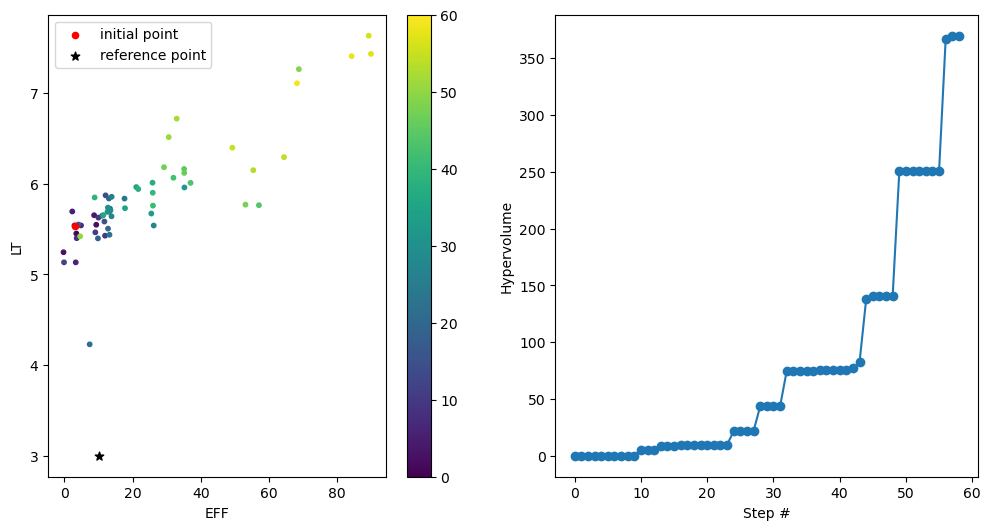

In [24]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i,df=opt.data)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

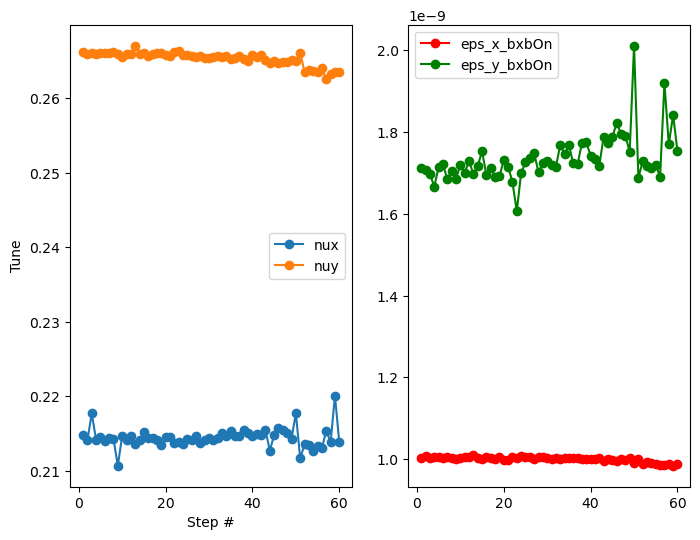

In [25]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [26]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][00:40:07.056 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:40:07.058 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2-P1': 0.0, 'SL2-P2': 0.0, 'SL2-P3': 0.0, 'SL2-P4': 0.0, 'SL2-P5': 0.0, 'SL3-P1': 0.0, 'SL3-P2': 0.0, 'SL3-P3': 0.0, 'SL3-P4': 0.0, 'SL3-P5': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][00:40:07.064 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2-P1': 7.135584290000001, 'SL2-P2': 7.135584290000001, 'SL2-P3': 7.135584290000001, 'SL2-P4': 7.135584290000001, 'SL2-P5': 7.135584290000001, 'SL3-P1': -5.892172122000001, 'SL3-P2': -5.892172122000001, 'SL3-P3': -5.892172122000001, 'SL3-P4': -5.892172122000001, 'SL3-P5': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 

SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2-P1 : +7.136 + +0.000 -> +7.136
SL2-P2 : +7.136 + +0.000 -> +7.136
SL2-P3 : +7.136 + +0.000 -> +7.136
SL2-P4 : +7.136 + +0.000 -> +7.136
SL2-P5 : +7.136 + +0.000 -> +7.136
SL3-P1 : -5.892 + +0.000 -> -5.892
SL3-P2 : -5.892 + +0.000 -> -5.892
SL3-P3 : -5.892 + +0.000 -> -5.892
SL3-P4 : -5.892 + +0.000 -> -5.892
SL3-P5 : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.090; RMS(dx, dy) [m] = (5.505e-06, 1.111e-06)
Orbit correction converged


[INFO ][00:40:14.221 opt_funcs.  734] Lifetime measurement START
[INFO ][00:40:20.652 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.440 (raw tau [hr] = 9.627, epsy [pm] = 18.68) (took 6.4 [s])
Inj. Eff. = 65.20 (took 19.9 [s])
Eval. func. finished.


[DEBUG][00:40:40.542 evaluators  211] Result: output={'result': {'_nux': 0.2153917332562703, '_nuy': 0.26336507403030673, '_eps_x_bxbOn': 9.817888418181093e-10, '_eps_y_bxbOn': 1.886779567243804e-11, '_eps_x_bxbOff': 9.85524421481284e-10, '_eps_y_bxbOff': 1.8683523861453124e-11, 'LT': 7.439835028745937, '_raw_LT': 9.626994211560232, 'EFF': 65.20163944973098}, 'exception': None, 'traceback': '', 'wall_time': 33.483678757213056, 'cpu_time': 12.753545640000084}
[DEBUG][00:40:40.545 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:40:40.626 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00054.json] in [0.07543]s


MOGA add_data (+1): len(self._offspring)=5/8


In [27]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][00:40:40.640 optimizer.  577] Evaluating 1 inputs
[DEBUG][00:40:40.642 evaluators  193] Data kwargs: row={'SH1N': -0.05, 'SH3N': 0.05, 'SH4N': -0.04, 'SL1': 0.08, 'SL2-P1': -0.27, 'SL2-P2': -0.34, 'SL2-P3': -0.41000000000000003, 'SL2-P4': -0.48000000000000004, 'SL2-P5': -0.55, 'SL3-P1': 0.13, 'SL3-P2': 0.06, 'SL3-P3': -0.010000000000000009, 'SL3-P4': -0.08000000000000002, 'SL3-P5': -0.15000000000000002, 'SH1-DW08': 0.025, 'SH1-DW18': -0.025, 'SH1-DW28': -0.025, 'SH3-DW08': 0.025, 'SH3-DW18': -0.025, 'SH3-DW28': -0.025, 'SH4-DW08': 0.025, 'SH4-DW18': -0.025, 'SH4-DW28': -0.025}
[INFO ][00:40:40.648 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9165824200000006, 'SH3N': -1.1210216819999999, 'SH4N': -3.2041801420000002, 'SL1': -2.5743212100000004, 'SL2-P1': 6.865584290000001, 'SL2-P2': 6.795584290000001, 'SL2-P3': 6.7255842900000005, 'SL2-P4': 6.65558429, 'SL2-P5': 6.585584290000001, 'SL3-P1': -5.762172122000001, 'SL3-P2': -5.832172122000001, 'SL3-P3': -5.9021721220000005, 'SL

SH1N   : +3.967 + -0.050 -> +3.917
SH3N   : -1.171 + +0.050 -> -1.121
SH4N   : -3.164 + -0.040 -> -3.204
SL1    : -2.654 + +0.080 -> -2.574
SL2-P1 : +7.136 + -0.270 -> +6.866
SL2-P2 : +7.136 + -0.340 -> +6.796
SL2-P3 : +7.136 + -0.410 -> +6.726
SL2-P4 : +7.136 + -0.480 -> +6.656
SL2-P5 : +7.136 + -0.550 -> +6.586
SL3-P1 : -5.892 + +0.130 -> -5.762
SL3-P2 : -5.892 + +0.060 -> -5.832
SL3-P3 : -5.892 + -0.010 -> -5.902
SL3-P4 : -5.892 + -0.080 -> -5.972
SL3-P5 : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.025 -> +3.992
SH1-DW18: +3.967 + -0.025 -> +3.942
SH1-DW28: +3.967 + -0.025 -> +3.942
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.025 -> -1.196
SH3-DW28: -1.171 + -0.025 -> -1.196
SH4-DW08: -3.164 + +0.025 -> -3.139
SH4-DW18: -3.164 + -0.025 -> -3.189
SH4-DW28: -3.164 + -0.025 -> -3.189
Sextupole adj. took 6.2.
Max FCOR I [A] = 0.119; RMS(dx, dy) [m] = (4.376e-06, 1.147e-06)
Max FCOR I [A] = 0.079; RMS(dx, dy) [m] = (2.855e-06, 1.145e-06)
Orbit correction converged


[INFO ][00:40:51.995 opt_funcs.  734] Lifetime measurement START
[INFO ][00:40:58.524 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 0 (out of 180)
Lifetime = 5.626 (raw tau [hr] = 6.712, epsy [pm] = 15.86) (took 6.5 [s])
Inj. Eff. = 18.91 (took 16.7 [s])
Eval. func. finished.


[DEBUG][00:41:15.188 evaluators  211] Result: output={'result': {'_nux': 0.2113634377737845, '_nuy': 0.26513509181247913, '_eps_x_bxbOn': 9.90094919659914e-10, '_eps_y_bxbOn': 1.604963409625464e-11, '_eps_x_bxbOff': 9.898900676743394e-10, '_eps_y_bxbOff': 1.5859249219792923e-11, 'LT': 5.625880261580107, '_raw_LT': 6.7121965402942045, 'EFF': 18.906048350203534}, 'exception': None, 'traceback': '', 'wall_time': 34.54516328778118, 'cpu_time': 13.059461322000061}
[DEBUG][00:41:15.190 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][00:41:15.284 optimizer. 1290] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-22_57_58-aps_mggpo-cd5ec93265-6d025b13/dump_auto_00055.json] in [0.08701]s


MOGA add_data (+1): len(self._offspring)=6/8


In [28]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2-P1,SL2-P2,SL2-P3,SL2-P4,SL2-P5,SL3-P1,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.050000,0.050000,-0.040000,0.080000,-0.270000,-0.340000,-0.410000,-0.480000,-0.550000,0.130000,...,True,0.214842,0.266142,1.002085e-09,1.712824e-11,1.002670e-09,1.699643e-11,5.537708,5.894315,2.948486
2,-0.056928,0.052255,-0.026680,0.073195,-0.277675,-0.333181,-0.422622,-0.488939,-0.566306,0.130872,...,True,0.214110,0.265929,1.007434e-09,1.706389e-11,1.005265e-09,1.689843e-11,5.449460,5.779384,3.478721
3,-0.041916,0.044704,-0.049313,0.087924,-0.242215,-0.357393,-0.400024,-0.446296,-0.543067,0.128430,...,True,0.217691,0.266051,1.003157e-09,1.697322e-11,1.004522e-09,1.706920e-11,5.546258,5.900207,9.319771
4,-0.063922,0.049836,-0.058776,0.071467,-0.310296,-0.361584,-0.444659,-0.472908,-0.575284,0.106042,...,True,0.214110,0.265929,1.006125e-09,1.666587e-11,1.004046e-09,1.665304e-11,5.243315,5.544313,-0.276788
5,-0.037199,0.054148,-0.036208,0.089652,-0.249397,-0.305514,-0.377909,-0.515886,-0.512562,0.152159,...,True,0.214537,0.266112,1.005864e-09,1.714806e-11,1.002955e-09,1.707741e-11,5.650856,6.055425,8.697717
6,-0.027306,0.047407,-0.033111,0.065363,-0.233988,-0.314827,-0.372826,-0.505725,-0.525403,0.099579,...,True,0.214018,0.266051,1.002856e-09,1.721762e-11,1.001519e-09,1.711024e-11,5.692530,6.111508,2.283209
7,-0.071608,0.055617,-0.050895,0.095508,-0.285482,-0.376416,-0.439199,-0.463084,-0.586773,0.158901,...,True,0.214385,0.265990,1.004990e-09,1.684698e-11,1.004513e-09,1.680582e-11,5.131557,5.451631,3.308130
8,-0.045970,0.050265,-0.041359,0.079063,-0.268282,-0.350588,-0.394946,-0.457461,-0.532987,0.146487,...,True,0.214273,0.266203,1.003831e-09,1.704556e-11,1.003173e-09,1.688434e-11,5.538667,5.884743,4.847879
9,-0.041916,0.044704,-0.049675,0.109624,-0.242215,-0.357632,-0.377078,-0.593009,-0.543067,0.128430,...,True,0.210677,0.265868,1.000855e-09,1.686000e-11,1.001013e-09,1.689749e-11,5.398222,5.775802,3.589393
10,-0.050089,0.050004,-0.026680,0.080031,-0.277675,-0.333181,-0.422379,-0.488939,-0.566196,0.130871,...,True,0.214720,0.265532,1.002962e-09,1.719870e-11,1.002207e-09,1.720997e-11,5.624557,6.065507,9.963247


In [29]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')